In [1]:
from datamatrix import io
import numpy as np
from matplotlib import pyplot as plt
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = np.inf
MIN_X = 4
MAX_X = 156
MIN_Y = 4
MAX_Y = 124
MIN_SD = 1
MAX_SD = 60
XC = 80
YC = 64


def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle('../outputs/correlation-matrix.pkl')
ldm = io.readtxt('../outputs/longish-correlation-matrix.csv')
for row in dm:
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    sd = row.prf_sd.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y) |
        (sd < MIN_SD) | (sd >= MAX_SD)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lc, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lc = [np.nanmedian(row.r_vc_lc.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
print('Before {}'.format(len(ldm)))
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
print('After {}'.format(len(ldm)))

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater_equal


Before 54720
After 34941


# Overall correlation per ROI

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


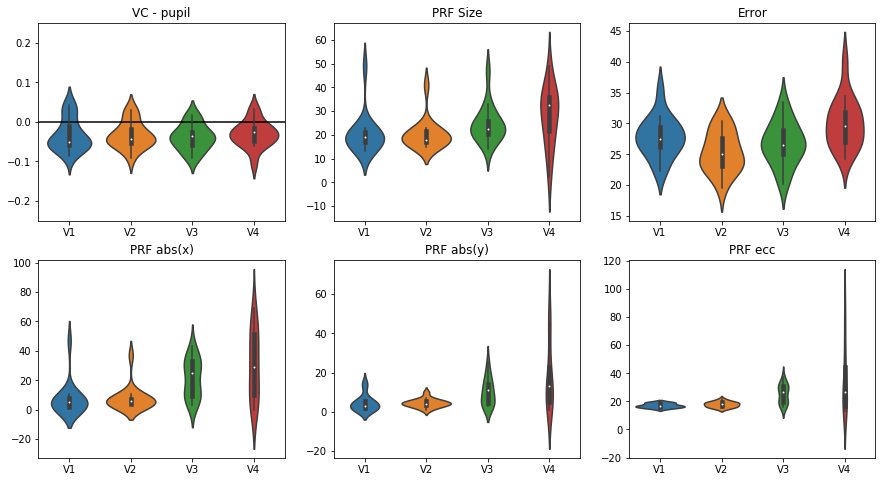

In [3]:
import seaborn as sns

plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
plt.title('VC - pupil')
plt.axhline(0, color='black')
plt.ylim(-.25, .25)
sns.violinplot(x='roi', y='r_pupil', data=dm)
plt.subplot(2,3,2)
plt.title('PRF Size')
sns.violinplot(x='roi', y='m_prf_sd', data=dm)
plt.subplot(2,3,3)
plt.title('Error')
sns.violinplot(x='roi', y='m_prf_err', data=dm)
plt.subplot(2,3,4)
plt.title('PRF abs(x)')
sns.violinplot(x='roi', y='m_prf_absx', data=dm)
plt.subplot(2,3,5)
plt.title('PRF abs(y)')
sns.violinplot(x='roi', y='m_prf_absy', data=dm)
plt.subplot(2,3,6)
plt.title('PRF ecc')
sns.violinplot(x='roi', y='m_prf_ecc', data=dm)


# Visual-field map of correlations

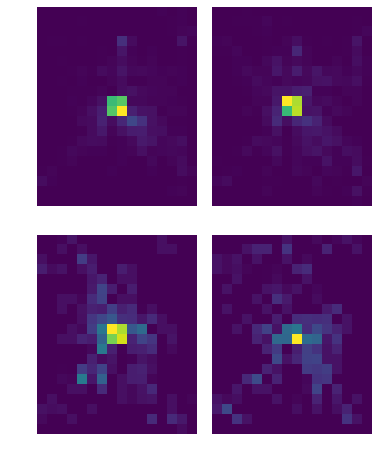

In [4]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * XC // downsample, 2 * YC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[x, y] += 1
    plt.axis('off')
    plt.imshow(a)
        
    
plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)    
density_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
density_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
density_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
density_map(ldm.roi == 'V4')

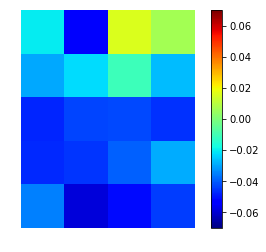

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


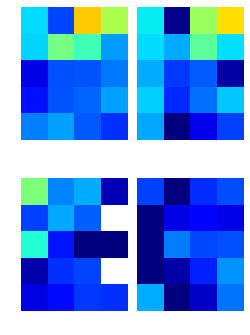

In [5]:
def correlation_map(ldm, downsample=32):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap, interpolation='none', vmin=-.07, vmax=.07, cmap='jet')
        

correlation_map(ldm)
plt.colorbar()
plt.show()
    
plt.figure(figsize=(4, 6))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)    
correlation_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
correlation_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
correlation_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
correlation_map(ldm.roi == 'V4')

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


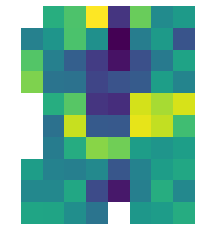

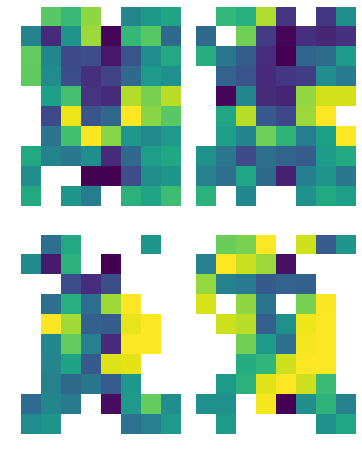

In [6]:
def size_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * XC // downsample, 2 * YC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, x, y] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    plt.imshow(heatmap)
        
    
size_map(ldm)
plt.show()
plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.subplot(2, 2, 1)
size_map(ldm.roi == 'V1')
plt.subplot(2, 2, 2)    
size_map(ldm.roi == 'V2')
plt.subplot(2, 2, 3)    
size_map(ldm.roi == 'V3')
plt.subplot(2, 2, 4)    
size_map(ldm.roi == 'V4')

# Statistics

In [7]:
from datamatrix.rbridge import lme4
lme4.verbose = True

## Relationship between PRF properties and the VC-pupil correlation.

In [8]:
lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
14.000620124636,(Intercept),-0.0372088359247819,0.000533877189235175,0.00833366518342876,-4.46488251037136


In [9]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.000410226701,(Intercept),-0.035270758413834,0.00232256507561265,0.00950246614367458,-3.71174786424389
13.9895917094925,c_roi,-0.00325522349611616,0.276239926744572,0.00287298014613317,-1.13304768238565


In [10]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
27.125200692775,(Intercept),-0.0476084559043356,1.48979118312572e-06,0.00777154830602286,-6.12599369258757
17.254878806723,prf_y,0.000157773304108917,0.00429738118470491,4.80227500788253e-05,3.28538669380545


In [11]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
34.2677377004428,(Intercept),-0.0316341509355919,0.000214501672616073,0.00764250804272133,-4.13923685245186
21.4803185832651,prf_x,-8.1637042806652e-05,0.0892329452749631,4.5864232417478e-05,-1.77997185396134


In [12]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
22.7353856981342,(Intercept),-0.0371521051020718,3.88690620588702e-05,0.00730349357670238,-5.08689501974567
15.0078478974673,ecc,-1.04992086085389e-06,0.989839244719991,8.10827665823142e-05,-0.0129487547737783


In [13]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
23.2234835354232,(Intercept),-0.0276307849492113,0.00655063378982102,0.00925156052590529,-2.98660802919057
17.9458029503407,prf_sd,-0.000314601259756943,0.072601555708335,0.000164935662993869,-1.90741804438399


## Basic PRF properties as a function of ROI.

In [14]:
lme4.lmer(ldm, 'ecc ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0112746313533,(Intercept),20.3080147876861,1.19592919454643e-07,2.072991074217,9.7964796087493
13.9628833215284,c_roi,3.89691881859569,0.000174302619691411,0.76957997650012,5.06369570102124


In [15]:
lme4.lmer(ldm, 'prf_sd ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0004129907833,(Intercept),27.4786915177165,3.18882936969778e-09,2.10696438933437,13.0418395568601
13.9886381924611,c_roi,3.82811081575413,0.000471600111261047,0.844913858135048,4.53077053819876


In [16]:
lme4.lmer(ldm, 'prf_sd ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
2.18156849427681,(Intercept),23.8320442255495,0.0122353531608062,3.03143234170929,7.86164477354346
8.37104594374805,ecc,0.293958971254925,1.71501249030473e-05,0.0336003816584379,8.74867953117742


In [18]:
from nilearn import plotting as nip

In [26]:
from datamatrix._datamatrix import _nifticolumn
_nifticolumn._set_globals()
nft = dm.r_vc_pupil.mean
a = nft.get_data()
nip.view_img(nft)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/datamatrix/_datamatrix/_nifticolumn.py:62: RuntimeWarning: Mean of empty slice
  return f(np.nanmean(data, axis=0), self.affine)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:543: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:121: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_